In [1]:
import SimpleITK as sitk
import os, glob
import json
import numpy as np
from PIL import Image
from skimage.color import label2rgb
import skimage.segmentation as seg
import torch
import torch.nn.functional as F
import cc3d
from tqdm import tqdm
from scipy.ndimage import binary_fill_holes
from pqdm.processes import pqdm
from pytorch_fid import fid_score
import time
from utils import *
from projections_essentials import *


/home/haicore-project-kit-iar-cvhci/pc8928/anaconda3/envs/translation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
cur_out_dir = os.path.join('/hkfs/work/workspace/scratch/pc8928-xray_training/PAnDa')

fid_frontal, fid_lateral = get_fid(cur_out_dir, '/hkfs/work/workspace/scratch/pc8928-xray_training/train/xray')

print('{} - Frontal FID: {}; Lateral FID: {}'.format(name, fid_frontal, fid_lateral))

In [5]:
root = '/hkfs/work/workspace/scratch/pc8928-ct_challenges/raw_data_base/nnUNet_raw_data/Task160_RibSegIndv_H3'

out_dir = '/hkfs/work/workspace/scratch/pc8928-xray_training/transfer'

files = glob.glob(os.path.join(root, 'imagesT*/*.nii.gz'))
image_1_path = files[2]


In [7]:
images_1 = sitk.ReadImage(image_1_path)
images_1_array = sitk.GetArrayFromImage(images_1)
images_1_array = np.clip(images_1_array, -1024, 3071)

In [8]:
images_1_array.shape

(417, 512, 512)

In [27]:
images_1_array_resized = sitk.GetArrayFromImage(resample_volume(images_1, new_spacing = [2,2,2]))
images_1_array_resized = np.clip(images_1_array_resized, -1024, 3071)

# Visualize Directions simply

In [69]:
name = 'default_sum'
cur_out_dir = os.path.join(out_dir,name)
process_folder(files, default_transfer, cur_out_dir, 1)
process_folder(files, default_transfer, cur_out_dir, 2)

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:01<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

In [77]:
name = 'default_sum'
cur_out_dir = os.path.join(out_dir,name)

fid_frontal, fid_lateral = get_fid(cur_out_dir)

print('{} - Frontal FID: {}; Lateral FID: {}'.format(name, fid_frontal, fid_lateral))

100%|██████████| 30/30 [01:06<00:00,  2.22s/it]


default_sum - Frontal FID: 143.17406925645687; Lateral FID: 155.40864347027485


# Exclude External Areas

In [10]:
name = 'noexterior_sum'
cur_out_dir = os.path.join(out_dir,name)
process_folder(files, noexterior_transfer, cur_out_dir, 1)
process_folder(files, noexterior_transfer, cur_out_dir, 2)

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:01<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:01<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

In [11]:
name = 'noexterior_sum'
cur_out_dir = os.path.join(out_dir,name)

fid_frontal, fid_lateral = get_fid(cur_out_dir)

print('{} - Frontal FID: {}; Lateral FID: {}'.format(name, fid_frontal, fid_lateral))

100%|██████████| 30/30 [01:07<00:00,  2.25s/it]


noexterior_sum - Frontal FID: 145.44972353756236; Lateral FID: 169.345469477746


In [10]:
body = remove_backplate(images_1_array)

k = body[::-1].sum(1)

j = noexterior_transfer(images_1_array,1) #default_transfer(images_1_array,1)

# Try Weighting

In [10]:
name = 'bone_noexterior_sum'
cur_out_dir = os.path.join(out_dir,name)
process_folder(files, bone_noexterior_transfer, cur_out_dir, 1)
process_folder(files, bone_noexterior_transfer, cur_out_dir, 2)

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:01<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

In [11]:
name = 'bone_noexterior_sum'
cur_out_dir = os.path.join(out_dir,name)

fid_frontal, fid_lateral = get_fid(cur_out_dir)

print('{} - Frontal FID: {}; Lateral FID: {}'.format(name, fid_frontal, fid_lateral))

100%|██████████| 30/30 [01:07<00:00,  2.25s/it]


bone_noexterior_sum - Frontal FID: 171.74458839077204; Lateral FID: 172.3338814242576


In [ ]:
Image.open(glob.glob(cur_out_dir+'/0/*')[50])

# Try hist equalization

In [65]:
name = 'hist_sum'
cur_out_dir = os.path.join(out_dir,name)
process_folder(files, hist_transfer, cur_out_dir, 1)
process_folder(files, hist_transfer, cur_out_dir, 2)

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

In [66]:
name = 'hist_sum'
cur_out_dir = os.path.join(out_dir,name)

fid_frontal, fid_lateral = get_fid(cur_out_dir)

print('{} - Frontal FID: {}; Lateral FID: {}'.format(name, fid_frontal, fid_lateral))

100%|██████████| 30/30 [01:08<00:00,  2.28s/it]


hist_sum - Frontal FID: 137.6527763943463; Lateral FID: 154.43769268684042


In [58]:
name = 'bone_hist_sum'
cur_out_dir = os.path.join(out_dir,name)
process_folder(files, bone_hist_transfer, cur_out_dir, 1)
process_folder(files, bone_hist_transfer, cur_out_dir, 2)

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

In [61]:
name = 'bone_hist_sum'
cur_out_dir = os.path.join(out_dir,name)

fid_frontal, fid_lateral = get_fid(cur_out_dir)

print('{} - Frontal FID: {}; Lateral FID: {}'.format(name, fid_frontal, fid_lateral))

100%|██████████| 30/30 [01:08<00:00,  2.27s/it]


bone_hist_sum - Frontal FID: 163.93819347125435; Lateral FID: 189.1783738396478


In [59]:
name = 'noexterior_hist_sum'
cur_out_dir = os.path.join(out_dir,name)
process_folder(files, noexterior_hist_transfer, cur_out_dir, 1)
process_folder(files, noexterior_hist_transfer, cur_out_dir, 2)

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

In [60]:
name = 'noexterior_hist_sum'
cur_out_dir = os.path.join(out_dir,name)

fid_frontal, fid_lateral = get_fid(cur_out_dir)

print('{} - Frontal FID: {}; Lateral FID: {}'.format(name, fid_frontal, fid_lateral))

100%|██████████| 30/30 [01:08<00:00,  2.30s/it]


noexterior_hist_sum - Frontal FID: 148.97734342267603; Lateral FID: 190.5070779565683


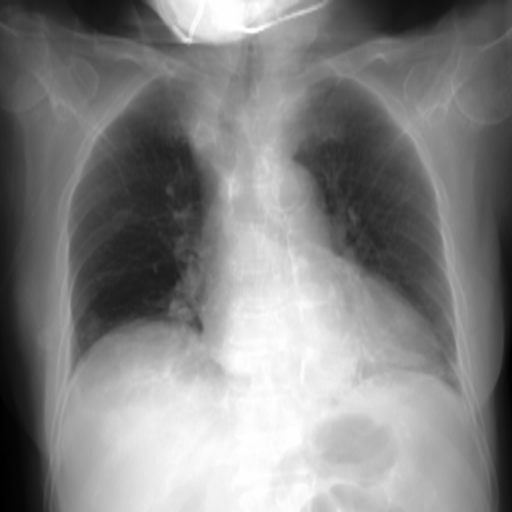

In [86]:
Image.fromarray(fin(hist_before_resized_transfer(images_1_array, 1))).resize((512,512))

# MATSUBARA

0.07310199737548828
2.589538812637329


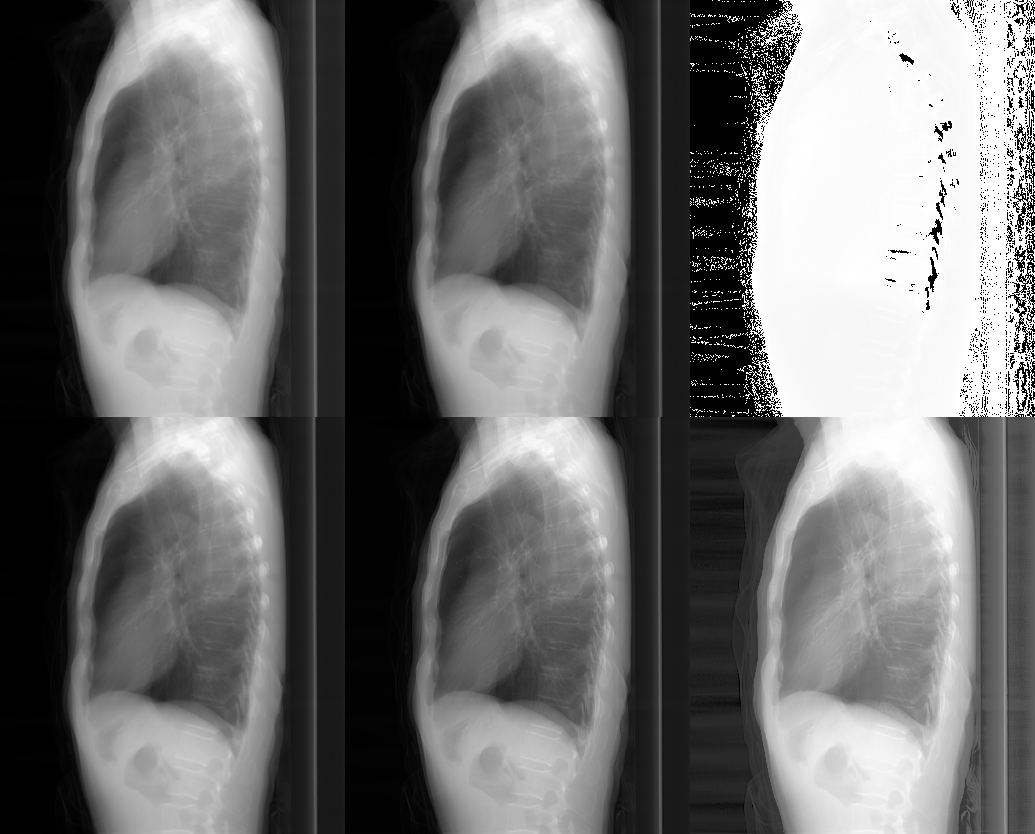

In [16]:

axis = 2

a = time.time()
fin(matsu_transfer(images_1_array_resized,axis ))
print(time.time()-a)

a = time.time()
fin(numba_matsu_transfer(images_1_array_resized,axis ))
print(time.time()-a)

o = fin(matsu_transfer(images_1_array_resized,axis ))
t = fin(nonlinear_matsu_transfer(images_1_array_resized,axis))
b = fin(bone_matsu_transfer(images_1_array_resized,axis))
s = fin(sharpening_mastu_transfer(images_1_array_resized,axis))
h = fin(hist_mastu_transfer(images_1_array_resized,axis))

out = np.concatenate(
        [
            np.concatenate([o,t, b-t],1),
            np.concatenate([b,s, h],1),
        ]
        , 0)
Image.fromarray((out).astype(np.uint8))#.resize((1024,512))

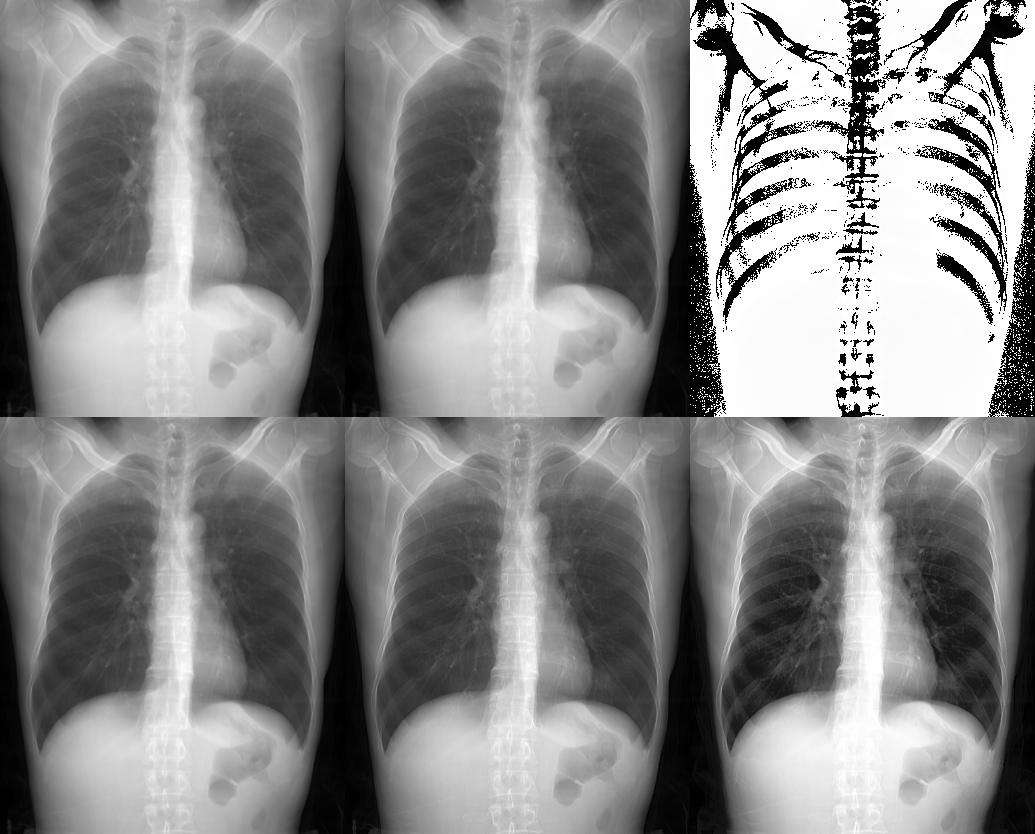

In [18]:
axis = 1

o = fin(matsu_transfer(images_1_array_resized,axis ))
t = fin(nonlinear_matsu_transfer(images_1_array_resized,axis))
b = fin(bone_matsu_transfer(images_1_array_resized,axis))
s = fin(sharpening_mastu_transfer(images_1_array_resized,axis))
h = fin(hist_mastu_transfer(images_1_array_resized,axis))

out = np.concatenate(
        [
            np.concatenate([o,t, b-t],1),
            np.concatenate([b,s, h],1),
        ]
        , 0)
Image.fromarray((out).astype(np.uint8))#.resize((1024,512))

# Resize 

In [ ]:

for h in range(0, 96, 16):
    for w in range(0, 64, 16):
        name = 'hist_resized_h{}_w{}_sum'.format(h,w)
        cur_out_dir = os.path.join(out_dir,name)
        process_folder_resize(files, hist_resized_transfer, cur_out_dir, h, w, 1)
        process_folder_resize(files, hist_resized_transfer, cur_out_dir, h, w, 2)
        
        fid_frontal, fid_lateral = get_fid(cur_out_dir)
        print('{} - Frontal FID: {}; Lateral FID: {}'.format(name, fid_frontal, fid_lateral))
    

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

In [96]:
name = 'bone_hist_resized_sum'
cur_out_dir = os.path.join(out_dir,name)
process_folder(files, bone_hist_resized_transfer, cur_out_dir, 1)
process_folder(files, bone_hist_resized_transfer, cur_out_dir, 2)

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

In [97]:
name = 'bone_hist_resized_sum'
cur_out_dir = os.path.join(out_dir,name)

fid_frontal, fid_lateral = get_fid(cur_out_dir)

print('{} - Frontal FID: {}; Lateral FID: {}'.format(name, fid_frontal, fid_lateral))

100%|██████████| 30/30 [01:08<00:00,  2.28s/it]


bone_hist_resized_sum - Frontal FID: 142.82231031728477; Lateral FID: 158.48784009733686


In [98]:
name = 'noexterior_hist_resized_sum'
cur_out_dir = os.path.join(out_dir,name)
process_folder(files, noexterior_hist_resized_transfer, cur_out_dir, 1)
process_folder(files, noexterior_hist_resized_transfer, cur_out_dir, 2)

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

In [99]:
name = 'noexterior_hist_resized_sum'
cur_out_dir = os.path.join(out_dir,name)

fid_frontal, fid_lateral = get_fid(cur_out_dir)

print('{} - Frontal FID: {}; Lateral FID: {}'.format(name, fid_frontal, fid_lateral))

100%|██████████| 30/30 [01:10<00:00,  2.34s/it]


noexterior_hist_resized_sum - Frontal FID: 128.29265464617237; Lateral FID: 165.7914964120877


In [87]:
name = 'hist_resized_sum'
cur_out_dir = os.path.join(out_dir,name)
process_folder(files, hist_resized_transfer, cur_out_dir, 1)
process_folder(files, hist_resized_transfer, cur_out_dir, 2)

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:01<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

In [88]:
name = 'hist_resized_sum'
cur_out_dir = os.path.join(out_dir,name)

fid_frontal, fid_lateral = get_fid(cur_out_dir)

print('{} - Frontal FID: {}; Lateral FID: {}'.format(name, fid_frontal, fid_lateral))

100%|██████████| 30/30 [01:09<00:00,  2.30s/it]


hist_resized_sum - Frontal FID: 127.28417124937152; Lateral FID: 140.7831753977272


In [89]:
name = 'hist_before_resized_sum'
cur_out_dir = os.path.join(out_dir,name)
process_folder(files, hist_before_resized_transfer, cur_out_dir, 1)
process_folder(files, hist_before_resized_transfer, cur_out_dir, 2)

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/356 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/356 [00:00<?, ?it/s]

In [90]:
name = 'hist_before_resized_sum'
cur_out_dir = os.path.join(out_dir,name)

fid_frontal, fid_lateral = get_fid(cur_out_dir)

print('{} - Frontal FID: {}; Lateral FID: {}'.format(name, fid_frontal, fid_lateral))

100%|██████████| 30/30 [01:07<00:00,  2.27s/it]


hist_before_resized_sum - Frontal FID: 127.24997500394184; Lateral FID: 138.69589476271858
